In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Features engineering
## Input: transactions dataset (name: transactions 2018)
## Output: dataset with features for profiling normalized (name: data)

In [2]:
df=pd.read_csv("transactions2018.csv")
df.head()

,index,Account_No,DATE,TRANSACTION_DETAILS,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,year,month,day,type,AMOUNT
0,0,409000611074',2018-01-01,INDO GIBL Indiaforensic STL31121,14000.0,0.0,697823.0,2018,1,1,PAYEMENT,14000.0
1,1,409000611074',2018-01-01,INDO GIBL Indiaforensic STL30121,54250.0,0.0,643573.0,2018,1,1,DEBIT,54250.0
2,2,409000611074',2018-01-02,INDO GIBL Indiaforensic STL01011,147500.0,0.0,496073.0,2018,1,2,PAYEMENT,147500.0
3,3,409000611074',2018-01-03,FDRL/INTERNAL FUND TRANSFE,0.0,500000.0,996073.0,2018,1,3,TRANSFER,500000.0
4,4,409000611074',2018-01-03,INDO GIBL Indiaforensic STL02011,323500.0,0.0,672573.0,2018,1,3,PAYEMENT,323500.0


In [3]:
profiling_df=df.drop(["index","Account_No","TRANSACTION_DETAILS","DATE","WITHDRAWAL_AMT","DEPOSIT_AMT","year","type","month","day"], axis=1)

In [4]:
profiling_df.head()

,BALANCE_AMT,AMOUNT
0,697823.0,14000.0
1,643573.0,54250.0
2,496073.0,147500.0
3,996073.0,500000.0
4,672573.0,323500.0


In [5]:
profiling_df.skew()

BALANCE_AMT    -3.957188
AMOUNT         31.617975
dtype: float64

In [6]:
profiling_df['AMOUNT']=np.log(profiling_df['AMOUNT'])

In [7]:
#Standarize features values to apply clustering methods
def df_clustering_std(df_clustering):
    features=list(df_clustering.columns)
    x = df_clustering.loc[:, features].values
    #Standardizing the features
    x = StandardScaler().fit_transform(x)
    d=df_clustering
    d[features] =x
    return d

In [8]:
data=df_clustering_std(profiling_df)

In [9]:
data.head()

,BALANCE_AMT,AMOUNT
0,0.729389,-0.340374
1,0.728997,0.044054
2,0.727931,0.327924
3,0.731545,0.674389
4,0.729206,0.550817


# Clustering model
## Input: dataset data
## Output:  number of clusters (k)
## +  Centroids coordinates (centroids)
## + Cluster of each point (labels)

In [10]:
def plot_k(df_clustering_std):
    features=list(df_clustering_std.columns)
    X1 = df_clustering_std[features].iloc[: , :].values
    inertia = []
    for n in range(1 , 11):
        algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                            tol=0.0001,  random_state= 111  , algorithm='elkan') )
        algorithm.fit(X1)
        inertia.append(algorithm.inertia_)

    #Selecting N Clusters based in Inertia (Squared Distance between Centroids and data points, should be less)
    plt.figure(1 , figsize = (10 ,6))
    plt.plot(np.arange(1 , 11) , inertia , 'o')
    plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    return plt.show()

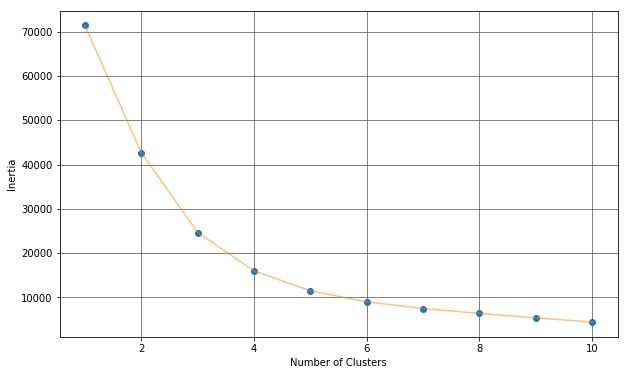

In [11]:
plot_k(data)

In [12]:
def kmeans(df_clustering_std,k):
    features=list(df_clustering_std.columns)
    algorithm = (KMeans(n_clusters = k ,init='k-means++', n_init = 10 ,max_iter=300, 
                            tol=0.0001,  random_state= 111  , algorithm='elkan') )
    X1 = df_clustering_std[features].iloc[: , :].values
    algorithm.fit(X1)
    labels = algorithm.labels_
    centroids = algorithm.cluster_centers_
    labelsncentroids=[labels,centroids]
    return labelsncentroids

In [13]:
k=4
labels=kmeans(data,4)[0]
centroids=kmeans(data,4)[1]

# Centroids table

In [14]:
centroids_table=pd.DataFrame()
centroids_table["profils"]=list(range(0,k))

In [15]:
# ADD Centroids coordinates for each cluster (profile)
a=[]
for i in range(len(list(centroids))):
    a.append(list(centroids)[i][0])
centroids_table["Balance_AMT_score"]=a

b=[]
for i in range(len(list(centroids))):
    b.append(list(centroids)[i][1])
centroids_table["AMOUNT_score"]=b

In [16]:
centroids_table

,profils,Balance_AMT_score,AMOUNT_score
0,0,-0.031899,1.058027
1,1,0.765778,-1.026542
2,2,-6.317620,0.360474
3,3,-0.468313,-0.191317


In [17]:
list(centroids)[0][0]

-0.031898789746013796

In [18]:
# add cluster number to each point in data and df
data["cluster"]=labels
df["cluster"]=labels

In [19]:
data["Account_No"]=df["Account_No"]

In [20]:
data.head(1)

,BALANCE_AMT,AMOUNT,cluster,Account_No
0,0.729389,-0.340374,1,409000611074'


# Scores computing
## Input: dataset data
##  Output: df with scores and sub-scores variables


### 1) Get cluster (profile) number for each client

In [21]:
clients=list(df["Account_No"].unique())

In [ ]:
# for acc in clients:
#     print(acc)
#     print(data[data["Account_No"]==acc]["cluster"].value_counts())

In [22]:
#add the variable cluster_max to dataset data

data['cluster_max']=0
for acc in clients:
    cond=data["Account_No"]==acc
    data['cluster_max']=data['cluster_max'].mask(cond, data[cond]["cluster"].value_counts().index[0])

In [23]:
data.head(1)

,BALANCE_AMT,AMOUNT,cluster,Account_No,cluster_max
0,0.729389,-0.340374,1,409000611074',0


In [24]:
centroids_table.head(1)

,profils,Balance_AMT_score,AMOUNT_score
0,0,-0.031899,1.058027


In [30]:
#add coordinates of centroids of cluster_max to dataset data:

data['bal_centroid']=0
data['amount_centroid']=0

for i in range(len(centroids_table)):
    
    bal_centroid_0=centroids_table["Balance_AMT_score"][i]
    amount_centroid_0=centroids_table["AMOUNT_score"][i]
    cond=data["cluster_max"]==i
    data['bal_centroid']=data["bal_centroid"].mask(cond,bal_centroid_0)
    data['amount_centroid']=data["amount_centroid"].mask(cond,amount_centroid_0)

In [33]:
# data

In [34]:
# centroids_table

### 2) Use the centroids of cluster_max to compute distance between points and centroid

In [36]:
data.head(1)

,BALANCE_AMT,AMOUNT,cluster,Account_No,cluster_max,bal_centroid,amount_centroid
0,0.729389,-0.340374,1,409000611074',0,-0.031899,1.058027


In [37]:
data["balance_score"]=np.abs(data["BALANCE_AMT"]- data["bal_centroid"])
data["amount_score"]=np.abs(data["AMOUNT"]- data["amount_centroid"])
data["transaction_score"]=data["amount_score"]+data["balance_score"]

In [38]:
data.head(1)

,BALANCE_AMT,AMOUNT,cluster,Account_No,cluster_max,bal_centroid,amount_centroid,balance_score,amount_score,transaction_score
0,0.729389,-0.340374,1,409000611074',0,-0.031899,1.058027,0.761288,1.398401,2.159689


In [39]:
# Add the variable "is_normal" THAT takes 1 if the transaction is normal according to the clustering (its cluster is the cluster_max ) and takes 0 if not
cond= data["cluster_max"]== data["cluster"]
data["is_normal"]=0
data["is_normal"]= data["is_normal"].mask(cond,1)

In [40]:
data.head()

,BALANCE_AMT,AMOUNT,cluster,Account_No,cluster_max,bal_centroid,amount_centroid,balance_score,amount_score,transaction_score,is_normal
0,0.729389,-0.340374,1,409000611074',0,-0.031899,1.058027,0.761288,1.398401,2.159689,0
1,0.728997,0.044054,1,409000611074',0,-0.031899,1.058027,0.760896,1.013973,1.774869,0
2,0.727931,0.327924,0,409000611074',0,-0.031899,1.058027,0.759829,0.730103,1.489932,1
3,0.731545,0.674389,0,409000611074',0,-0.031899,1.058027,0.763444,0.383638,1.147082,1
4,0.729206,0.550817,0,409000611074',0,-0.031899,1.058027,0.761105,0.507210,1.268315,1


In [45]:
# data[data["Account_No"]==clients[2]] ["is_normal"].value_counts()

### 3) Add thresholds

In [52]:
profiles=list(data["cluster_max"].unique())

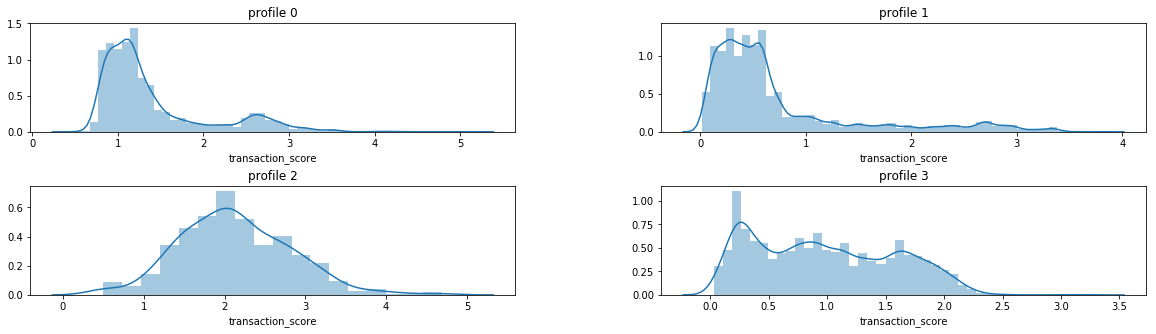

In [56]:
plt.figure(1 , figsize = (20 , 5))
n = 0 
for x in profiles:
    n += 1
    plt.subplot(2 , 2 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    sns.distplot(data[data["cluster_max"]==x]["transaction_score"])

    plt.title( "profile " + str(x) )
plt.show()



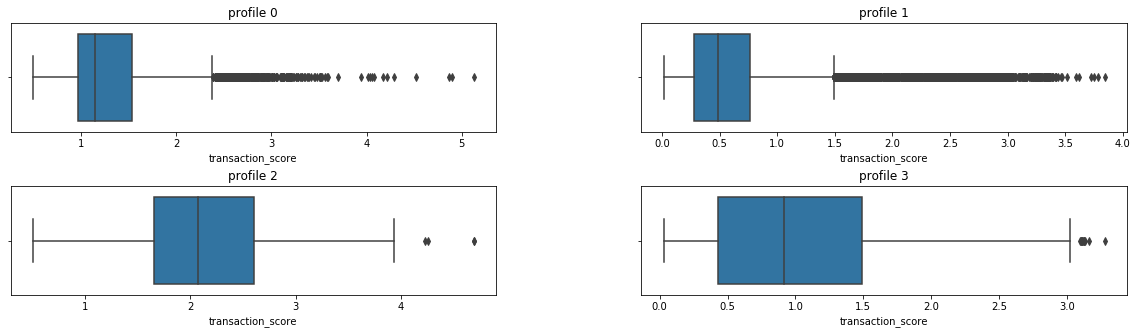

In [57]:
plt.figure(1 , figsize = (20 , 5))
n = 0 
for x in profiles:
    n += 1
    plt.subplot(2 , 2 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    sns.boxplot(x=data[data["cluster_max"]==x]["transaction_score"])


    plt.title( "profile " + str(x) )
plt.show()


In [58]:
# Point on the outliers in each profile
q3=data[data["cluster_max"]==x]["transaction_score"].quantile(0.75)


In [61]:
# data["risk_is_medium"]=0
# q3=data[data["cluster_max"]==x]["transaction_score"].quantile(0.75)
# cond_q=data[data["cluster_max"]==x]["transaction_score"]>q3
# data["risk_is_medium"]=data["risk_is_medium"].mask(cond_q,1)

In [66]:
data["q3_threshold"]=0

for x in profiles:
    cond_q=data["cluster_max"]==x
    q3=data[data["cluster_max"]==x]["transaction_score"].quantile(0.75)
    data["q3_threshold"]=data["q3_threshold"].mask(cond_q,q3)

In [68]:
np.max(data[data["cluster_max"]==x]["transaction_score"])

3.2787214964854896

In [69]:
data["max_threshold"]=0

for x in profiles:
    cond_max=data["cluster_max"]==x
    maxi=np.max(data[data["cluster_max"]==x]["transaction_score"])
    data["max_threshold"]=data["max_threshold"].mask(cond_max,maxi)

In [71]:
data.head(1)

,BALANCE_AMT,AMOUNT,cluster,Account_No,cluster_max,bal_centroid,amount_centroid,balance_score,amount_score,transaction_score,is_normal,q3_threshold,max_threshold
0,0.729389,-0.340374,1,409000611074',0,-0.031899,1.058027,0.761288,1.398401,2.159689,0,1.535815,5.12666


In [72]:
scores=pd.DataFrame()
scores[["Account_No","cluster_max","balance_score","amount_score",
        "transaction_score","is_normal","q3_threshold","max_threshold"]]=data[["Account_No","cluster_max","balance_score","amount_score",
                                                                                                                                         "transaction_score","is_normal","q3_threshold","max_threshold"]]

In [73]:
scores.to_csv ('transactions_scores_1.0.csv', index = None, header=True)


In [74]:
clients

["409000611074'",
 "409000493201'",
 "409000425051'",
 "409000405747'",
 "409000438611'",
 "409000493210'",
 "409000438620'",
 "1196711'",
 "1196428'",
 "409000362497'",
 'A',
 'B']